# Optimizing bottom oxygen - dye from model output to observed hypoxic areas

In [17]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib


from okean import roms
import datetime

from sklearn import preprocessing
from scipy.stats.stats import pearsonr
from scipy import optimize

from tracpy.plotting import background

import tracpy

%matplotlib inline

##TX-LA Hindcast model

In [2]:
#grd_path = 'http://barataria.tamu.edu:8080/thredds/dodsC/txla_nesting6_grid/txla_grd_v4_new.nc'
grd_path = '/Users/vrx/Projects/txla_o/txla_grd_v4_new.nc'
his_path = 'http://barataria.tamu.edu:8080/thredds/dodsC/NcML/txla_nesting6.nc'
grd = roms.Grid(grd_path)
r = roms.His(his_path,grd_path)

#for plotting
grid = tracpy.inout.readgrid(grd_path, usebasemap=True, llcrnrlat=22.85, llcrnrlon=-97.9, urcrnrlat=30.5)
xpsi = np.asanyarray(grid['xpsi'].T, order='C')
ypsi = np.asanyarray(grid['ypsi'].T, order='C')

#grid cell area
# dA = 1./(grd.pm*grd.pn)


sat = 320
vmin = 250
vmax = 330

##Observations from http://www.gulfhypoxia.net/

In [3]:
years = range(2003,2013)
obs_area = [8320, 14640, 11800, 16560, 20480, 21764, 8240, 18400, 17680, 7480]


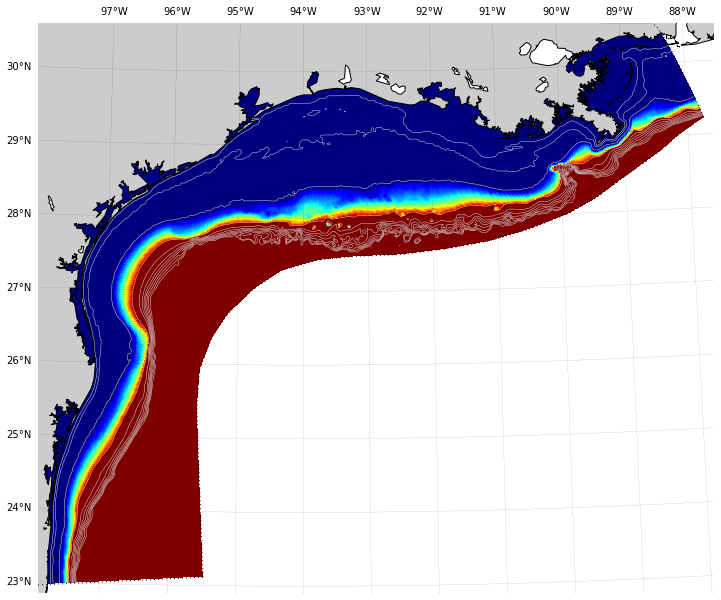

In [4]:
#weigths to clip dye values bellow 50 m.

#depths = np.load('/Users/vrx/Projects/txla_o/model_depth.npy')
#depths = grd.h

w = np.ones_like(grd.h)
w[grd.h<50.] = 0
idxw = np.where((grd.h>=50.) & (grd.h<=100.))
w[idxw] = (grd.h[idxw]-50.)/50.


fig = plt.figure(figsize=(10.1, 8.4), dpi=100)
ax = fig.add_axes([0.06, 0.00, 0.93, 0.97])
ax.set_frame_on(False) 
background(grid=grid, ax=ax, mers=np.arange(-97, -87), merslabels=[0, 0, 1, 0], pars=np.arange(23, 32))

mappable = ax.pcolormesh(xpsi, ypsi, w[1:-1,1:-1])


##Defining some functions

In [5]:
def get_ox(years, r, w):
    """get mean bottom oxygen for critical period in summer"""
    mbo = np.empty((len(years),r.grid.h.shape[0],r.grid.h.shape[1]))
    for n in range(len(years)):
        #time range for average
        ini = datetime.datetime(years[n],7,16,0,0)
        end = datetime.datetime(years[n],8,07,0,0)
        i_idx = np.where(r.time==ini)[0]
        e_idx = np.where(r.time== end)[0]
        ox_b = r.use('dye_01', s_rho=0, ocean_time=range(i_idx[0],e_idx[0]))
        #weigths
        ox_b = (1-w)*ox_b+w*sat
        mbo[n,:,:] = ox_b.mean(axis=0)
    return mbo

def calc_area(mbo,grd,h_min,o_crit):
    """get mean hypoxic area"""
    dA = 1./(grd.pm*grd.pn)
    area = []
    for n in range(mbo.shape[0]):
        mbo_ = np.squeeze(mbo[n,:,:])
        idx = np.where((mbo_<o_crit) & (grd.h>h_min))
        area.append(dA[idx].sum())
    return area

def calc_error(obs, model):
    """e, e_s: returns sum of squared errors for original values and scaled values"""   
    obs = np.asarray(obs, dtype=float)*1e6
    model = np.asarray(model)
    err = (obs-model)**2
    obs_s = preprocessing.scale(obs)
    model_s = preprocessing.scale(model)
    err_s = (obs_s-model_s)**2
    return err.sum(), err_s.sum()

###Model area

In [8]:
# mbo = np.load('/Users/vrx/Projects/txla_o/mbo.npy')
# dA = np.load('/Users/vrx/Projects/txla_o/dA.npy')
# depths = np.load('/Users/vrx/Projects/txla_o/model_depth.npy')

mbo = get_ox(years,r,w)

o_crit = np.arange(0,vmax, 10)

m_area = []
pearson = []
err = np.empty((len(o_crit),2))
for n in range(len(o_crit)):
    area = calc_area(mbo,grd,5,o_crit[n])
    m_area.append(area)
    pearson.append(pearsonr(obs_area, area))
    err[n,:] = calc_error(obs_area, area)

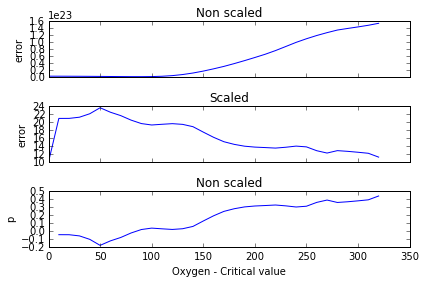

In [10]:
f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(o_crit,err[:,0])
axarr[0].set_title('Non scaled')
axarr[0].set_ylabel('error')

axarr[1].plot(o_crit,err[:,1])
axarr[1].set_title('Scaled')
axarr[1].set_ylabel('error')

corr = np.asarray(pearson)
axarr[2].plot(o_crit,corr[:,0])
axarr[2].set_title('Non scaled')
axarr[2].set_ylabel('p')

plt.xlabel('Oxygen - Critical value')
plt.tight_layout()
plt.savefig('modelobs.png')

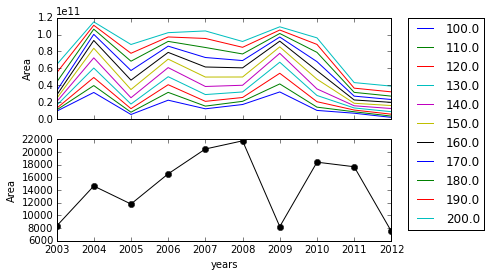

In [11]:
val = np.linspace(100, 200, 11)
f, axarr = plt.subplots(2, sharex=True)

for v in val:
    model = calc_area(mbo,grd,5,v)
    axarr[0].plot(years, model, label = v)
axarr[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axarr[0].set_ylabel('Area')
axarr[1].plot(years,obs_area, '-ok')
axarr[1].set_ylabel('Area')
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
plt.xlabel('years')


###Clipped area

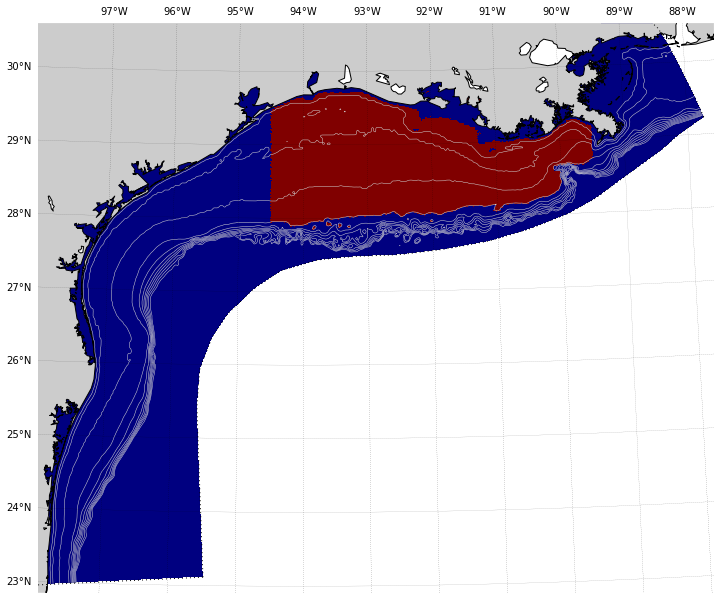

In [12]:
#clip area to observatios area
llon = -94.5
rlon = -89.5
ulat = 29.72

masks = [grd.h>5., grd.h <100, grd.lon> llon, grd.lon<rlon, grd.lat<ulat ]
total_mask = reduce(np.logical_and, masks)


fig = plt.figure(figsize=(10.1, 8.4), dpi=100)
ax = fig.add_axes([0.06, 0.00, 0.93, 0.97])
ax.set_frame_on(False) 
background(grid=grid, ax=ax, mers=np.arange(-97, -87), merslabels=[0, 0, 1, 0], pars=np.arange(23, 32))

mappable = ax.pcolormesh(xpsi, ypsi, total_mask[1:-1,1:-1])

In [13]:
def calc_area2(mbo, grd, h_min, o_crit):
    """get mean hypoxic area"""
    dA = 1./(grd.pm*grd.pn)
    area = []
    for n in range(mbo.shape[0]):
        mbo_ = np.squeeze(mbo[n,:,:])
        idx = np.where((mbo_<o_crit) & (grd.h>5.) & (grd.lon>llon) &(grd.lon<rlon)&(grd.lat<ulat))
        area.append(dA[idx].sum())
    return area

In [14]:
print(calc_area2(mbo, grd, 5, 500)[0])


96919628781.2


In [15]:
m_area2 = []
pearson2 = []
err2 = np.empty((len(o_crit),2))
for n in range(len(o_crit)):
    area = calc_area2(mbo, grd, 5, o_crit[n])
    m_area2.append(area)
    pearson2.append(pearsonr(obs_area, area))
    err2[n,:] = calc_error(obs_area, area)


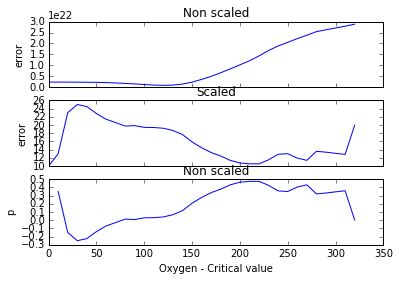

In [16]:
f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(o_crit,err2[:,0])
axarr[0].set_title('Non scaled')
axarr[0].set_ylabel('error')

axarr[1].plot(o_crit,err2[:,1])
axarr[1].set_title('Scaled')
axarr[1].set_ylabel('error')

corr = np.asarray(pearson2)
axarr[2].plot(o_crit,corr[:,0])
axarr[2].set_title('Non scaled')
axarr[2].set_ylabel('p')

plt.xlabel('Oxygen - Critical value')
plt.savefig('new.png')

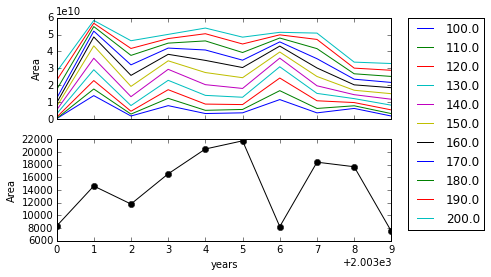

In [18]:
val = np.linspace(100, 200, 11)
f, axarr = plt.subplots(2, sharex=True)

for v in val:
    model = calc_area2(mbo,grd, 5,v)
    axarr[0].plot(years, model, label = v)
axarr[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axarr[0].set_ylabel('Area')
axarr[1].plot(years,obs_area, '-ok')
axarr[1].set_ylabel('Area')
plt.xlabel('years')


##Optimization

In [27]:
def cost_fun1(o_crit):
    obs_area_ = obs_area
    grd_ = grd
    mbo_ = mbo

    area = calc_area(mbo_, grd_, 5, o_crit)

    e, e_s = calc_error(obs_area_, area)
    
    return e_s

optimize.fmin(cost_fun1, 200)

Optimization terminated successfully.
         Current function value: 13.413608
         Iterations: 19
         Function evaluations: 43


array([ 218.28857422])

In [29]:

def cost_fun2(o_crit):
#     years = range(2003,2013)
    obs_area_ = obs_area
    grd_ = grd
    mbo_ = mbo

    area = calc_area2(mbo_, grd_, 5, o_crit)

    e, e_s = calc_error(obs_area_, area)
    return e_s

optimize.fmin(cost_fun2, 200)


Optimization terminated successfully.
         Current function value: 10.409277
         Iterations: 19
         Function evaluations: 44


array([ 215.92285156])

optimize.brute(


In [44]:
optimize.differential_evolution(cost_fun2, [(0,320)])

    nfev: 92
 success: True
     fun: 10.420773155165652
       x: array([ 217.13767871])
 message: 'Optimization terminated successfully.'
     nit: 5

In [37]:
slice(0., 320, 0.1)

slice(0.0, 320, 0.1)

##Plotting

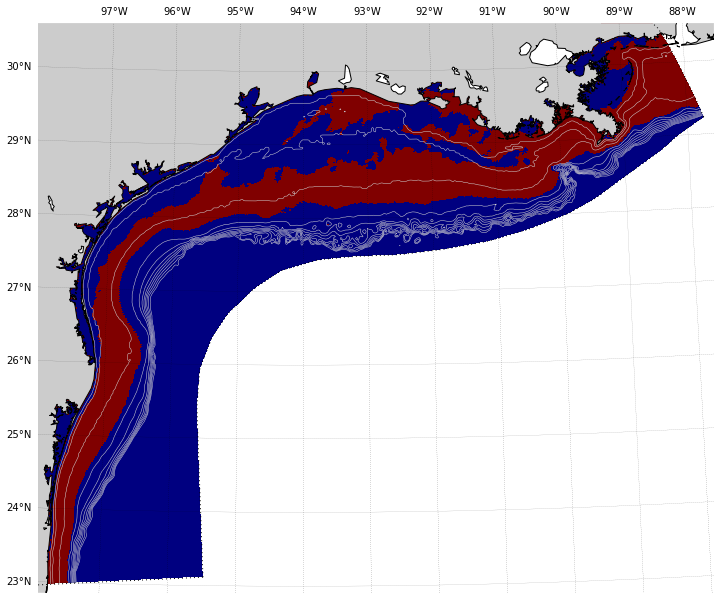

In [46]:
mask = np.ma.masked_where(mbo<=217,mbo)

oxy = np.squeeze(mask.mask[0,1:-1,1:-1])

fig = plt.figure(figsize=(10.1, 8.4), dpi=100)
ax = fig.add_axes([0.06, 0.00, 0.93, 0.97])
ax.set_frame_on(False) 
background(grid=grid, ax=ax, mers=np.arange(-97, -87), merslabels=[0, 0, 1, 0], pars=np.arange(23, 32))

mappable = ax.pcolormesh(xpsi, ypsi, oxy)


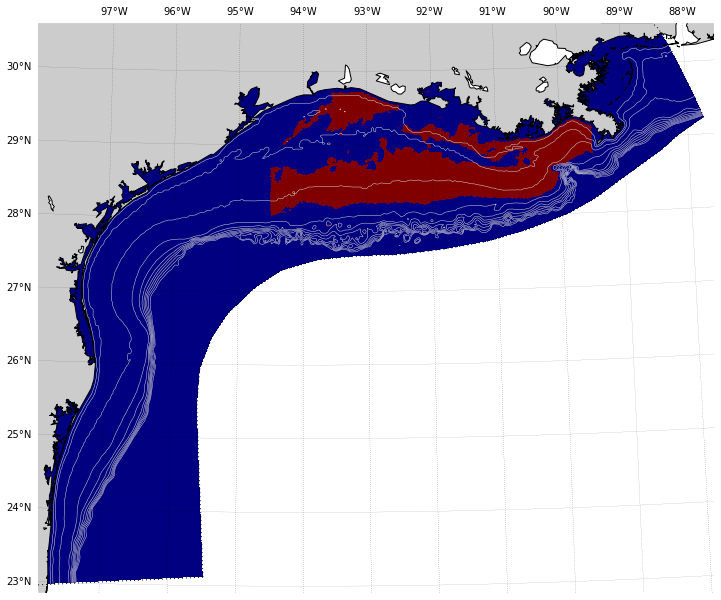

In [47]:

masks = [mbo<217, grd.h>5., grd.lon> llon, grd.lon<rlon, grd.lat<ulat]
total_mask = reduce(np.logical_and, masks)


#mask = np.ma.masked_where(mbo<=150,mbo)

oxy = np.squeeze(total_mask[0,1:-1,1:-1])

fig = plt.figure(figsize=(10.1, 8.4), dpi=100)
ax = fig.add_axes([0.06, 0.00, 0.93, 0.97])
ax.set_frame_on(False) 
background(grid=grid, ax=ax, mers=np.arange(-97, -87), merslabels=[0, 0, 1, 0], pars=np.arange(23, 32))

mappable = ax.pcolormesh(xpsi, ypsi, oxy)

